In [1]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

import logging
import os, sys
from datetime import datetime

# ---------- Add project root to path ----------
from dotenv import find_dotenv, load_dotenv
load_dotenv(find_dotenv(), verbose=True) # Example:  AWS_ACCESS_KEY_ID = os.environ.get("AWS_ACCESS_KEY")
PROJECT_ROOT = os.environ.get("PROJECT_ROOT")
sys.path.append(PROJECT_ROOT)
# ----------------------------------------------

from src.common.plots import Visualize as V
from src.models_service.models_service import TensorflowModelService as TFModelService
from src.models_service.errors import ErrorsCalculation as ErrorCalc
from src.common.globals import G
from src.data.get_data import CSVsLoader
from src.common.logs import setup_logging, log_model_info


logger = setup_logging(logger_name=__name__,
                        console_level=logging.INFO, 
                        log_file_level=logging.INFO)

PROJECT_PATH = G.get_project_root()
DATA_DIR_PROCESSED = os.path.join(PROJECT_PATH, r'data\03_processed\daily_full')

config = {
    'AV': {
        'key': '',
        'ticker': 'MSFT',
        'outputsize': 'full',
        'key_adjusted_close': 'Adj Close',
        'key_volume': 'Volume',
    },
    'data': {
        'test_size': 0.05,
    }, 
    'model': {
        'name': 'LSTM', 
        'window': 20,
        'batch_size' : 32,
        'shuffle_buffer_size' : 5600, # https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
        'epochs' : 6,
        'optimizer': tf.keras.optimizers.Adam(),
        'loss': tf.keras.losses.Huber(),
    },
    'plots': {
        'loss_zoom': 0.9,
    },
}

In [2]:
def label_column_to_end(df, last_column):
    ''' 
    Changes positions of columns in df to put the target column at the end

    Args:
        df (pandas dataframe) - dataframe to change
        last_column (string) - name of the column to put at the end
        
    Returns:
        df (pandas dataframe) - dataframe with the target column at the end
    '''
    cols = df.columns.tolist()
    cols.remove(last_column)
    cols.append(last_column)
    return df[cols]

In [3]:
def windowed_dataset_X(df, window_size, logger, verbose=True):
    '''
    Creates a windowed dataset X from a dataframe

    Args:
        df (pandas dataframe) - dataframe to create the dataset from
        window_size (int) - size of the window
        logger (logger) - logger to use
        verbose (bool) - whether to print debug info or not

    Returns:
        dataset (tf dataset) - dataset with the windowed data
        scalers (dict) - dictionary with the scalers used for each column
    '''
    # change the position of the target column to the end
    df = label_column_to_end(df, 'Adj Close')

    X_df = df.iloc[:, :-1]
    y_df = df.iloc[:, -1:]

    scalers = {}
    for col in X_df.columns:
        scaler = MinMaxScaler()
        X_df[col] = scaler.fit_transform(X_df[col].values.reshape(-1,1))
        scalers[col] = scaler
    
    # Creating X and y
    X = X_df.values
    y = y_df.values
    if verbose:
        logger.info('---------------------------------X,y shape-----------------------------')
        logger.info (f'X.shape: {X.shape}, y.shape: {y.shape}')
        logger.info('-'*100)


    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(X)
    if verbose:
        logger.info('--------------------------from_tensor_slices--------------------------')
        for element in dataset:
            logger.info(element)
            break
        logger.info('-'*100)

    # Window the data but only take those with the specified size
    # And add + 1 to the window size to account for the label, which we will separate later
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    if verbose:
        logger.info('-------------------------------window-----------------------------------')
        for window in dataset:
            logger.info(type(window))
            logger.info(list(window.as_numpy_iterator()))
            break
        logger.info('-'*100)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    if verbose:
        logger.info('--------------------------------flat_map--------------------------------')
        for window in dataset:
            logger.info(window)
            break
        logger.info('-'*100)

    if verbose:
        logger.info(f'Lenght of X = {len(list(dataset.as_numpy_iterator()))}')

    return dataset, scalers

In [4]:
def windowed_dataset_y(df, window_size, logger, verbose=True):
    '''
    Creates a windowed dataset y from a dataframe

    Args:
        df (pandas dataframe) - dataframe to create the dataset from
        window_size (int) - size of the window
        logger (logger) - logger to use
        verbose (bool) - whether to print debug info or not

    Returns:
        dataset (tf dataset) - dataset with the windowed data
    '''
    # change the position of the target column to the end
    df = label_column_to_end(df, 'Adj Close')

    # Creating X and y
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1:].values
    if verbose:
        logger.info('---------------------------------X,y shape-------------------------------------')
        logger.info (f'X.shape: {X.shape}, y.shape: {y.shape}')
        logger.info('-'*100)
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(y)
    if verbose:
        logger.info('--------------------------from_tensor_slices--------------------------')
        for element in dataset:
            logger.info(element)
            break
        logger.info('-'*100)

    # calculate number of points we need to cut to make series evenly divisible by window_size
    remainder = window_size - 1

    # Remove the reminder elements from the end of dataset
    dataset = dataset.take(len(y) - remainder)
    if verbose:
        logger.info('--------------------------------take len(y)-reminder--------------------------------')
        for window in dataset:
            logger.info(window)
            break
        logger.info('-'*100)

    if verbose:
        logger.info(f'Lenght of y = {len(list(dataset.as_numpy_iterator()))}')
    
    return dataset

In [5]:
def split_train_test(df, test_size, logger):
    '''
    Splits a dataframe into train and test sets

    Args:
        df (pandas dataframe) - dataframe to split
        test_size (float) - size of the test set
        logger (logger) - logger to use

    Returns:
        df_train (pandas dataframe) - train set
        df_test (pandas dataframe) - test set
    '''

    test_size_int = int(len(df) * test_size)
    df_train = df.iloc[:-test_size_int].copy(deep=True)
    df_test = df.iloc[-test_size_int:].copy(deep=True)

    logger.info(f'df_train.shape: {df_train.shape}, df_test.shape: {df_test.shape}')

    return df_train, df_test

In [6]:
def drop_non_features(df):
    ''' 
    Drops all columns except for the Adj Close and the features
    
    Args:
        df (pandas dataframe) - dataframe to change
    Returns:
        df (pandas dataframe) - dataframe with only the Adj Close and the features
        '''
    for col in df.columns:
        if col != 'Adj Close' and col.endswith(' - 1') == False:
            df = df.drop(columns=[col])

    return df

In [7]:
def create_features(df, logger):
    '''
    Creates features from the original dataframe by shifting the columns by 1 day
    And then drops the columns that are not features or the 'Adj Close'

    Args:
        df (pandas dataframe) - dataframe to change
    Returns:
        df (pandas dataframe) - dataframe with only the Adj Close and the features
    '''
    for col in df.columns:
        df[f'{col} - 1'] = df[col].shift(1)
    df = df.dropna()
    df = drop_non_features(df)
    logger.info(f'df.shape: {df.shape}')
    logger.info(f'df.columns: {df.columns}')

    return df

In [8]:
def combine_datasets(train_dataset_X, train_dataset_y, config, logger, verbose=True):
    ''' 
    Combines the X and y datasets into one dataset
    Then shuffles the dataset
    Then batches the dataset
    Then prefetches the dataset
    
    Args:
        train_dataset_X (tf dataset) - dataset with the features
        train_dataset_y (tf dataset) - dataset with the target
        config (dict) - dictionary with the configuration
        logger (logger) - logger
        verbose (bool) - if True, prints the shape of the dataset
    Returns:
        zipped_dataset (tf dataset) - dataset with the features and the target
    '''
    zipped_dataset = tf.data.Dataset.zip((train_dataset_X, train_dataset_y))
    zipped_dataset = zipped_dataset.shuffle(config['model']['shuffle_buffer_size'])
    zipped_dataset = zipped_dataset.batch(config['model']['batch_size']).prefetch(1)

    if verbose:
        for x, y in zipped_dataset:
            logger.info(f'x.shape: {x.numpy().shape}, y.shape: {y.numpy().shape}')
            break
    
        input_shape = zipped_dataset.element_spec[0].shape
        logger.info(f'Full Dataset shape: {input_shape}')
        logger.info(f'Input for the model: {input_shape[1:]}')

    return zipped_dataset

In [9]:
# -----------------------------Data----------------------------------------
df = CSVsLoader(ticker=config['AV']['ticker'], directory=DATA_DIR_PROCESSED)
df_train, df_test = split_train_test(df, config['data']['test_size'], logger)
df_train = create_features(df_train, logger)
df_test = create_features(df_test, logger)

2023-09-21 17:01:50 - src.data.get_data - INFO - Loaded "..\P7-Trading-Bot\data\03_processed\daily_full\MSFT-daily-full.csv". Number data points 5995. From "1999-11-01 00:00:00" to "2023-08-29 00:00:00"
2023-09-21 17:01:50 - __main__ - INFO - df_train.shape: (5696, 2), df_test.shape: (299, 2)
2023-09-21 17:01:50 - __main__ - INFO - df.shape: (5695, 3)
2023-09-21 17:01:50 - __main__ - INFO - df.columns: Index(['Adj Close', 'Adj Close - 1', 'Volume - 1'], dtype='object')
2023-09-21 17:01:50 - __main__ - INFO - df.shape: (298, 3)
2023-09-21 17:01:50 - __main__ - INFO - df.columns: Index(['Adj Close', 'Adj Close - 1', 'Volume - 1'], dtype='object')


In [10]:
train_dataset_X, scalers_X = windowed_dataset_X(df_train, 
                                                window_size=config['model']['window'], 
                                                logger=logger,
                                                verbose=False)

In [11]:
train_dataset_y = windowed_dataset_y(df_train, 
                                     window_size=config['model']['window'], 
                                     logger=logger,
                                     verbose=False)

In [12]:
train_dataset = combine_datasets(train_dataset_X, train_dataset_y, config, logger, verbose=False)

In [13]:
# -----------------------------Model Architecture--------------------------
model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(None,2)),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1),
        ],
    name=config['model']['name'])

model._name = f"{model._name}_{str(model.count_params())}_{datetime.now().strftime('%Y-%m-%d--%H-%M')}"
log_model_info(config, model, logger)

2023-09-21 17:01:50 - __main__ - INFO - ==============================================================================================
2023-09-21 17:01:50 - __main__ - INFO - =================================== MODEL CONFIG AND SETUP ===================================
2023-09-21 17:01:50 - __main__ - INFO - ==============================================================================================
2023-09-21 17:01:50 - __main__ - INFO - AV_key: , AV_ticker: MSFT, AV_outputsize: full, AV_key_adjusted_close: Adj Close, AV_key_volume: Volume, 
2023-09-21 17:01:50 - __main__ - INFO - data_test_size: 0.05, 
2023-09-21 17:01:50 - __main__ - INFO - ----------------------------------------------------------------------
2023-09-21 17:01:50 - __main__ - INFO - model_name: LSTM
2023-09-21 17:01:50 - __main__ - INFO - model_window: 20
2023-09-21 17:01:50 - __main__ - INFO - model_batch_size: 32
2023-09-21 17:01:50 - __main__ - INFO - model_shuffle_buffer_size: 5600
2023-09-21 17:01:50 - __main

Epoch 1/6
178/178 [==============================] - 7s 16ms/step - loss: 39.9462 - mae: 40.4362
Epoch 2/6
178/178 [==============================] - 2s 10ms/step - loss: 37.2435 - mae: 37.7308
Epoch 3/6
178/178 [==============================] - 2s 10ms/step - loss: 16.8001 - mae: 17.2740
Epoch 4/6
178/178 [==============================] - 2s 11ms/step - loss: 2.2414 - mae: 2.6679
Epoch 5/6
178/178 [==============================] - 2s 10ms/step - loss: 1.4785 - mae: 1.8784
Epoch 6/6
178/178 [==============================] - 3s 13ms/step - loss: 1.4241 - mae: 1.8280


2023-09-21 17:02:09 - src.common.plots - INFO - Plot "LSTM-MAE_and_Loss-2023-09-21_17-02-09-5.png" saved to "D:\Study 2018 and later\Mignimind Bootcamp\Code\P7-Trading-Bot\figures\LSTM-MAE_and_Loss-2023-09-21_17-02-09-5.png"


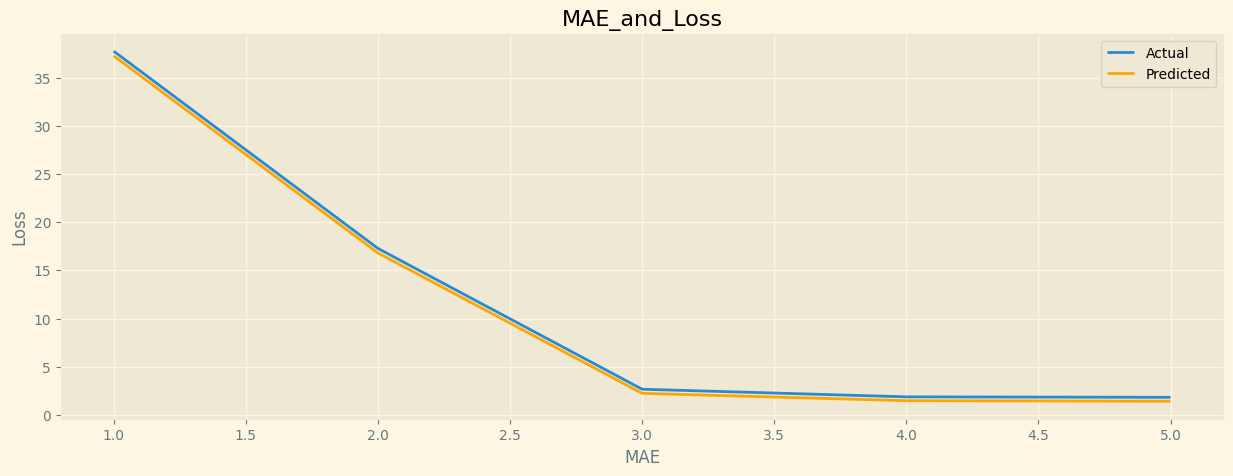

2023-09-21 17:02:09 - __main__ - INFO - Model saved as LSTM_42113_2023-09-21--17-01.keras


In [14]:
# Set the training parameters and train the model
model.compile(loss=config['model']['loss'], 
            optimizer=config['model']['optimizer'], 
            metrics=["mae"],
            )    

# Train the model
history = model.fit(train_dataset, epochs=config['model']['epochs'])

# Plot MAE and Loss
mae=history.history['mae']
loss=history.history['loss']
zoom = int(len(mae) * config['plots']['loss_zoom'])

V.plot_series(x=range(config['model']['epochs'])[-zoom:],
                y=(mae[-zoom:],loss[-zoom:]),
                model_name=config['model']['name'],
                title='MAE_and_Loss',
                xlabel='MAE',
                ylabel='Loss',
                legend=['MAE', 'Loss']
            )

# Save the model
TFModelService.save_model(model, logger)

In [15]:
def model_load(model_name):
    model = tf.keras.models.load_model(os.path.join(PROJECT_PATH, rf'models_trained\{model_name}.keras'))
    return model

In [16]:
def model_forecast(model, df, window_size, scalers:dict, verbose=True):
    '''
    Generates a forecast from the model

    Args:
        model (tf model) - model to use
        window_size (int) - size of the window
        df (pandas dataframe) - dataframe to create the dataset from
        scalers (dict) - dictionary with the scalers used for each column
        verbose (bool) - whether to logger.info debug info or not

    Returns:
        forecast (numpy array) - array with the forecast
    '''

    # change the position of the target column to the end
    df = label_column_to_end(df, 'Adj Close')
    if verbose:
        logger.info('---------------------------------df shape-------------------------------------')
        logger.info (f'df.shape: {df.shape}')
        logger.info(df.iloc[:2])
        logger.info('-'*100)

    X_df = df.iloc[:, :-1].copy(deep=True)
    if verbose:
        logger.info('---------------------------------X_df shape-------------------------------------')
        logger.info (f'X_df.shape: {X_df.shape}')
        logger.info(X_df.iloc[:2])
        logger.info('-'*100)

    # Scale the data
    for col in X_df.columns:
        scaler = scalers[col]
        X_df[col] = scaler.transform(X_df[col].values.reshape(-1,1))
    
    # Creating X
    X = X_df.values
    if verbose:
        logger.info('---------------------------------X shape-------------------------------------')
        logger.info (f'X.shape: {X.shape}')
        logger.info('-'*100)


    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(X)
    if verbose:
        logger.info('--------------------------from_tensor_slices--------------------------')
        for element in dataset:
            logger.info(element)
            break
        logger.info('-'*100)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    if verbose:
        logger.info('-------------------------------window-----------------------------------')
        for window in dataset:
            logger.info(type(window))
            logger.info(list(window.as_numpy_iterator()))
            break
        logger.info('-'*100)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    if verbose:
        logger.info('--------------------------------flat_map--------------------------------')
        for window in dataset:
            logger.info(window)
            break
        logger.info('-'*100)

    # batch the data
    dataset = dataset.batch(1)
    if verbose:
        logger.info('--------------------------------batch-----------------------------------')
        for batch in dataset:
            logger.info(batch)
            break
        logger.info('-'*100)
        
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    if verbose:
        logger.info('------------------------forecast for 2 first ---------------------------')
        for i,x in enumerate(forecast):
            if i > 1:
                break
            logger.info(f'(Prediction {i} - {x})')
            logger.info(f'Predicted shape: {forecast.shape}')
        logger.info('-'*100)


    forecast = forecast.squeeze()

    return forecast

In [17]:
def prep_test_df_shape(test_df, config):
    ''' 
    Prepares the test dataframe to plot the results.
    Where -config['model']['window']+1 is to account for the window size. 
    We can't predict for 19 days if the window size is 20, because we don't have the 20th day yet.
    Say we have 100 days, we can only predict for 81 days, because we don't have the 82nd day yet to form the window of 20 days.

    Args:
        test_df (pandas dataframe) - dataframe to change
        results (numpy array) - array with the forecast
        config (dict) - dictionary with the configuration
    Returns:
        df_test_minus_window (pandas dataframe) - dataframe with the last n days removed
    '''
    df_test_minus_window = test_df.iloc[:-config['model']['window']+1].copy(deep=True)
    return df_test_minus_window

279/279 [==============================] - 2s 3ms/step


2023-09-21 17:02:12 - src.common.plots - INFO - Plot "LSTM-None-2023-09-21_17-02-12-0.png" saved to "D:\Study 2018 and later\Mignimind Bootcamp\Code\P7-Trading-Bot\figures\LSTM-None-2023-09-21_17-02-12-0.png"


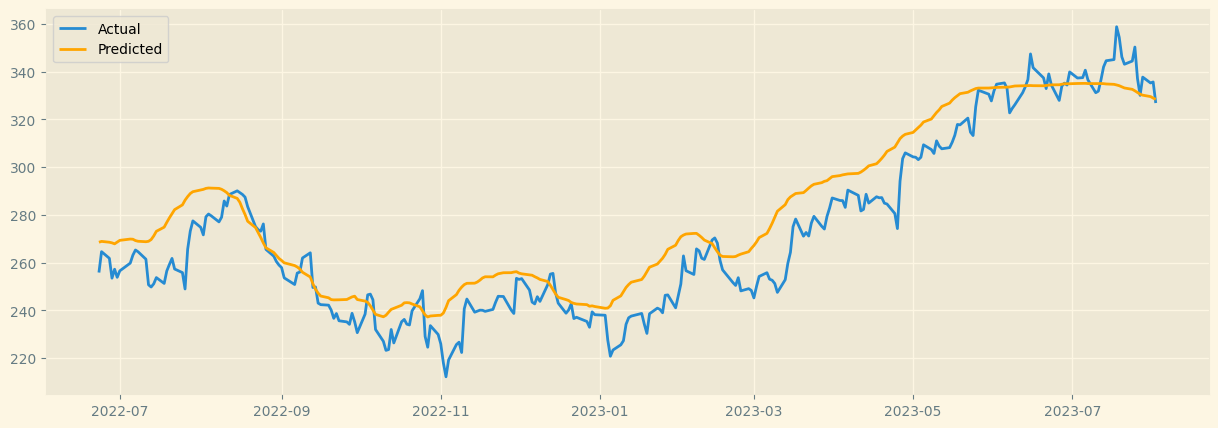

In [18]:
#--------------------------------------------------------------------------
# model = model_load(model_name='LSTM_42113_2023-09-20--15-58')

# -----------------------------Predictions---------------------------------
results = model_forecast(model=model, 
                        df=df_test,
                        window_size=config['model']['window'],
                        scalers=scalers_X,
                        verbose=False)

df_test_plot = prep_test_df_shape(df_test, config)

V.plot_series(  x=df_test_plot.index,  # as dates
                y=(df_test_plot['Adj Close'], results),
                model_name=config['model']['name'])

In [19]:
# -----------------------Calculate Errors----------------------------------
naive_forecast = ErrorCalc.get_naive_forecast(df).loc[df_test_plot.index] # Getting same days as results
rmse, mae, mape, mase = ErrorCalc.calc_errors(df_test_plot['Adj Close'], results, naive_forecast)
ErrorCalc.save_errors_to_table(config['model']['name'], {'rmse': rmse, 'mae': mae, 'mape': mape, 'mase': mase})

2023-09-21 17:02:12 - src.models_service.errors - INFO - Test RMSE: $ 13.451
2023-09-21 17:02:12 - src.models_service.errors - INFO - Test MAE : $ 11.156
2023-09-21 17:02:12 - src.models_service.errors - INFO - Test MAPE:   0.043
2023-09-21 17:02:12 - src.models_service.errors - INFO - Test MASE:   2.845
2023-09-21 17:02:12 - src.models_service.errors - INFO - Errors saved to for LSTM model to "logs/models_table.csv" file.
